In [2]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# Download the dataset, I used this small dataset for simplicity, 
# it contains 2000 images for training and 1000 images for validation.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2022-01-13 09:39:06--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.103.128, 108.177.120.128, 142.250.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.103.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   128MB/s    in 0.5s    

2022-01-13 09:39:07 (128 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [4]:
# Unzip the file
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [5]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [6]:
# Prepair the data
TRAINING_DIR = "/tmp/cats_and_dogs_filtered/train/"
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats_and_dogs_filtered/validation"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=20,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [12]:
# Train the model more than once to get better results
history = model.fit(train_generator, epochs=25, steps_per_epoch=70,
                    validation_data=validation_generator, validation_steps=6)

model.save('c-vs-d.model')

Epoch 1/25
70/70 [==============================] - 13s 191ms/step - loss: 0.4472 - acc: 0.8036 - val_loss: 0.4180 - val_acc: 0.8083
Epoch 2/25
70/70 [==============================] - 13s 191ms/step - loss: 0.4912 - acc: 0.7729 - val_loss: 0.4907 - val_acc: 0.7750
Epoch 3/25
70/70 [==============================] - 13s 189ms/step - loss: 0.4714 - acc: 0.7836 - val_loss: 0.4714 - val_acc: 0.7917
Epoch 4/25
70/70 [==============================] - 13s 190ms/step - loss: 0.4688 - acc: 0.7836 - val_loss: 0.4792 - val_acc: 0.7750
Epoch 5/25
70/70 [==============================] - 13s 190ms/step - loss: 0.4615 - acc: 0.7900 - val_loss: 0.5797 - val_acc: 0.7500
Epoch 6/25
70/70 [==============================] - 13s 191ms/step - loss: 0.4956 - acc: 0.7686 - val_loss: 0.5098 - val_acc: 0.8250
Epoch 7/25
70/70 [==============================] - 13s 191ms/step - loss: 0.4784 - acc: 0.7786 - val_loss: 0.3616 - val_acc: 0.8583
Epoch 8/25
70/70 [==============================] - 13s 192ms/step - 

<Figure size 432x288 with 0 Axes>

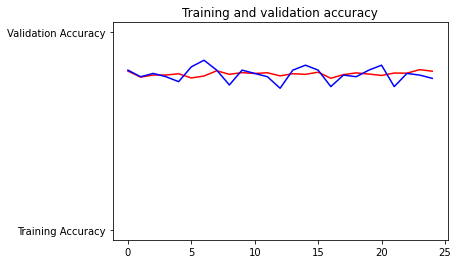

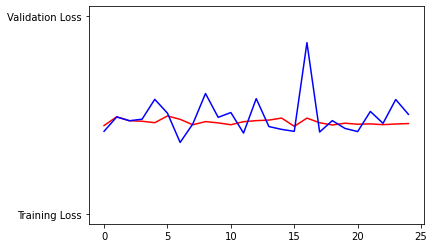

<Figure size 432x288 with 0 Axes>

In [13]:
model = tf.keras.models.load_model('c-vs-d.model')

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


# Retrieve a list of list results on training and test data sets for each training epoch

acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs


# Plot training and validation accuracy per epoch

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()


# Plot training and validation loss per epoch

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()

In [14]:
# Upload an image to the model to predict it
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a cat")
  else:
    print(fn + " is a dog")

Saving 947364_1579966548996109_2232711533243363832_n.jpg to 947364_1579966548996109_2232711533243363832_n.jpg
[1.]
947364_1579966548996109_2232711533243363832_n.jpg is a cat
